# This Notebook is the main notebook that makes and exports the following: 

- Machine learning Models: 
     1. Random forest
     2. Gradient boosted trees
- important functions to acutally makes things work faster     


# Imports

In [37]:
! pip install fastai --quiet

In [3]:
import pandas as pd, numpy as np
from glob import glob
import time
import os



from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
from fastai.imports import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Load and Transform the dataframe

In [4]:
def reward_levels_engineering(df):
    df["reward levels"] = df["reward levels"].str.replace("$", "", regex=False)
    df_split = df["reward levels"].str.split(",", expand=True)[[0]]
    df_split.columns = ['level_0']
    df_split = df_split.fillna("0")
    df_split = df_split.astype(int)
    df = df.join(df_split)
    return df


def load_df_and_clean(df):
    df = df.drop(columns=['project id'])
    df = df[df.levels <= 11]
    f = df.comments <= 1000
    df = df[f]
    df['funded date'] = pd.to_datetime(df['funded date'])
    df['year'] = df['funded date'].dt.year
    df = reward_levels_engineering(df) # apply necessary feature engineering for the reward levels
    return df    

In [5]:
df = pd.read_csv('video_games.csv')

In [6]:
df =  pd.read_csv('event_camp.csv', encoding_errors='ignore')

In [85]:
df.head(1)

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesabath/while-the-trees-sleep,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.0


In [86]:
df = load_df_and_clean(df)

In [87]:
# make a log transformation quickly and efficiently
def log_transform(df,col):
    df[col]= np.log1p(df[col])
    print(df[col].skew())
    
def set_range_col(df,col,l,r):
    # very cool state of the pledged money raised
    df =  df[(df[col] >= l) & (df[col] <= r)]
    print( df[(df[col] >= l) & (df[col] <= r)][col].skew())
    return df

In [88]:
dep_var = 'pledged'

log_transform(df,'pledged')

df = set_range_col(df,'pledged',2,11)

df['pledged'].skew()

log_transform(df,'goal')

df['goal'].skew()

-1.011312118792583
-0.5455045093007429
-0.11219109375207353


-0.11219109375207353

In [89]:
def deal_with_outliers(df,col):
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                      # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    upper_bound = np.ceil(upper_bound)
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers)}")

    df.loc[df[col] > upper_bound, col] = upper_bound

# Backers Deal with Outliers

In [90]:
deal_with_outliers(df,'backers')

log_transform(df,'backers')

Number of outliers: 2459
-0.34667673166110596


# Comments Outliers

In [91]:
deal_with_outliers(df,'comments')

log_transform(df,'comments')

Number of outliers: 3285
0.6147742005809352


In [92]:
# df['comments'].hist()

# Level_0 outliers

In [93]:
deal_with_outliers(df,'level_0')

Number of outliers: 2478


In [94]:
log_transform(df,'level_0')

0.10854147415712079


shall i log transform the level 0 ? 

In [95]:
df.columns

Index(['name', 'url', 'category', 'subcategory', 'location', 'status', 'goal',
       'pledged', 'funded percentage', 'backers', 'funded date', 'levels',
       'reward levels', 'updates', 'comments', 'duration', 'year', 'level_0'],
      dtype='object')

In [96]:
def drop_columns(df,cols = []):
    if cols: 
        df = df.drop(columns=cols)
    return df

In [97]:
df = drop_columns(df,cols=['reward levels'])

# combine all the steps together

In [ ]:
df =  pd.read_csv('event_camp.csv', encoding_errors='ignore')

In [98]:
def all_data_preprocessing(df):
    df = load_df_and_clean(df)
    
    dep_var = 'pledged'
    log_transform(df,'pledged')
    df = set_range_col(df,'pledged',2,11)

    log_transform(df,'goal')
    
    deal_with_outliers(df,'backers')

    log_transform(df,'backers')
    
    deal_with_outliers(df,'comments')

    log_transform(df,'comments')
    
    deal_with_outliers(df,'level_0')
    
    log_transform(df,'level_0') # shall we log transform it ? 
    
    df = drop_columns(df,cols=['reward levels'])
    
    return df

In [99]:
def train_test_split(df):
    total = df.shape[0]
    testing_portion = int(total * 0.05)
    
    # the splits
    training_data = total - testing_portion
    test_data = training_data + testing_portion


    df1 = df[:training_data]
    df_test = df[training_data:test_data]
    return df1, df_test

In [100]:
df1, df_test = train_test_split(df)

# Splitting the data

In [21]:
# 20% validation set
splits = RandomSplitter(valid_pct=0.2,seed=42)(df1)

In [22]:
len(splits[0]),len(splits[1]),len(df1)

(26562, 6640, 33202)

# Processing the data

In [23]:
procs = [Categorify,FillMissing]

# here the "1" means something i need to remind myself of
cont, cat = cont_cat_split(df1,9000,dep_var=dep_var)

In [24]:
to = TabularPandas(df1, procs,cat, cont,y_names=dep_var,splits=splits)

# CheckPoint

save what have you done so far...

In [25]:
save_pickle('./to_event.pkl',to)

# Make a decision Tree

In [26]:
to = load_pickle('./to_event.pkl')

In [27]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y 

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [30]:
# it is good to make your loss function from scratch for you to see how math's
# will be directly implemented inside the work that you have at hand
# let's make the rmse

import math
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m,xs,y): return r_mse(m.predict(xs),y)

In [31]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.0, 0.138357)

why the `validation error` is `higher than` the `training error` ? what's happening?

In [32]:
m.get_n_leaves(), len(xs)

(20082, 26562)

we have `512 datapoints`, and the decision tree have  478 leafs which means the decision tree literally memorized the training dataset, which is known in deep learning as `overfitting`

In [33]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.187054, 0.206137)

now they are closer to each other, and that's just better !

In [34]:
m.get_n_leaves() # very good result

810

very cool result, 15 leafs nodes only, that is cool

# Creating a RandomForest

In [35]:
from sklearn.ensemble import RandomForestRegressor

# we will make a function to traverse and try different parameters for the RandomForest
# n_estimators = 40 --> number of trees, if you have time and enough sleep increase this number
# max_samples = 200,000 rows , but we have 192,000 train datapoints , let's see if anything here breaks 
# max_features = 0.5 --> randomly take half the columns to train a single tree
# min_samples_leaf= 5 --> the final leaf node shall contain at least 5 rows of data (5 airplane tickets)
# n_jobs = -1 --> tell sklearn to use all of our CPU brain power to run this in parallel
# oob_score = True --> explain this later

# things to test here, increase the # of trees, use sklearn default max_feature, use the min_samples_leaf default of sklearn
# then report your findings

def rf(xs, y, n_estimators=500, max_samples=26562, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)




In [36]:
m = rf(xs,y)

In [37]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.101563, 0.147638)

In [38]:
def rf_feature_importance(m,df):
    return pd.DataFrame(
    {'cols':df.columns, 'imp':m.feature_importances_}
  ).sort_values('imp',ascending=False)

In [39]:
fi = rf_feature_importance(m,xs)
fi

,cols,imp
12,backers,0.504940
11,funded percentage,0.240151
10,goal,0.149824
5,status,0.059680
8,updates,0.019589
13,comments,0.013197
7,levels,0.003778
6,funded date,0.001346
15,level_0,0.001310
14,duration,0.001199


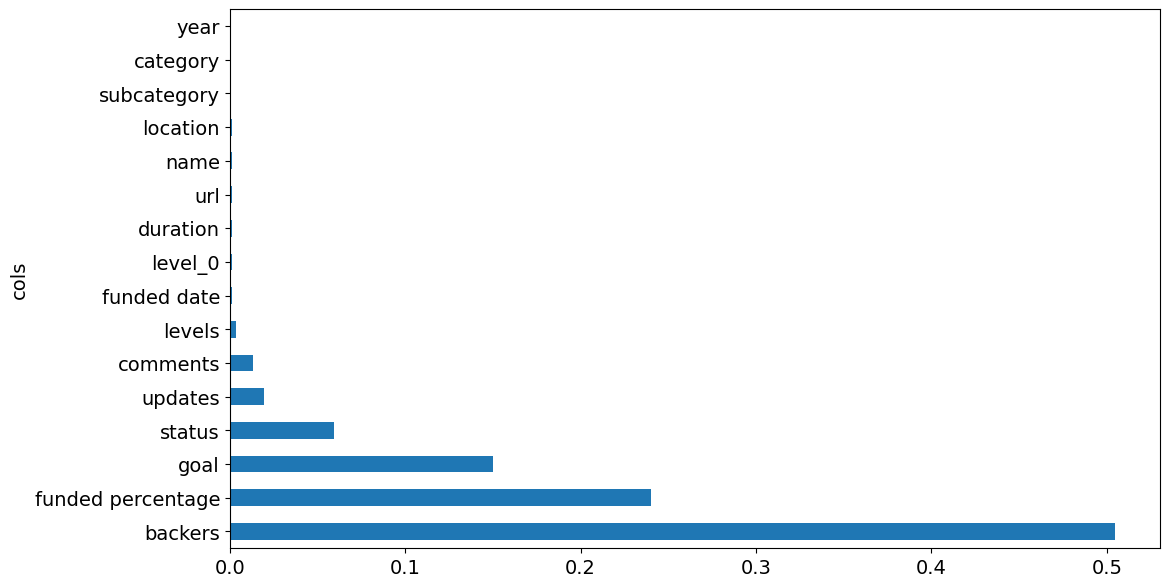

In [40]:
def plot_fi(fi): 
      return fi.plot('cols','imp','barh', figsize=(12,7),legend=False)

plot_fi(fi);

level_0, year, subcategory, category

In [41]:
to_keep = fi[fi.imp>0.005].cols
to_keep

12              backers
11    funded percentage
10                 goal
5                status
8               updates
13             comments
Name: cols, dtype: object

In [42]:
len(to_keep) , len(fi)

(6, 16)

In [43]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

valid_xs_imp.columns.tolist()

['backers', 'funded percentage', 'goal', 'status', 'updates', 'comments']

In [44]:
m = rf(xs_imp, y)

In [45]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.103917, 0.129932)

In [46]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp 

In [47]:
save_pickle('./xs_final.pkl', xs_final)
save_pickle('./valid_xs_final.pkl', valid_xs_final)

# Final Chosen Features

In [48]:
xs = load_pickle('./xs_final.pkl')
valid_xs = load_pickle('./valid_xs_final.pkl')

In [49]:
# make sure everything is going well
m = rf(xs,y)

In [50]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.103912, 0.129486)

# Water Fall 

how is the `xs` affecting the `y` {pledged}

In [51]:
! pip install treeinterpreter waterfallcharts --quiet

In [52]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [53]:
row = valid_xs.iloc[:10]
prediction,bias,contributions = treeinterpreter.predict(m,row.values)


In [54]:

prediction[2],bias[2],contributions[2].sum()

(array([9.31779573]), 6.962028425725608, 2.355767301929943)

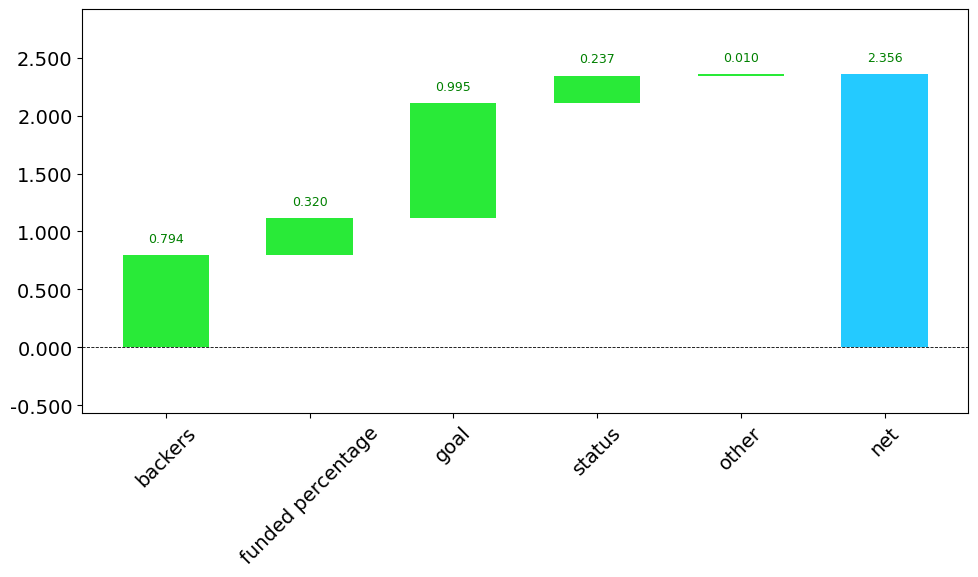

In [55]:

waterfall(
  valid_xs.columns, contributions[2], threshold=0.08,
  rotation_value=45, formatting='{:.3f}'
  );

### Testing The Random forest

In [56]:
dl_test = to.dataloaders().test_dl(df_test)
xs_test, y_test = dl_test.train.xs, dl_test.train.y
xs_test = xs_test[xs.columns.to_list()]

In [57]:
m_rmse(m,xs_test, y_test)

0.130638

we will see what happens when we load the whole dataset

# Neural Network 

In [58]:
df_nn = df1.copy()
df_nn_final = df_nn[xs.columns.to_list() + [dep_var]]

In [59]:
df_nn_final.shape

(33202, 7)

In [60]:
# 20% validation set
splits = RandomSplitter(valid_pct=0.2,seed=42)(range_of(df_nn_final))
len(splits[0]),len(splits[1])

(26562, 6640)

In [61]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

df_nn_final[cat_nn].nunique()

procs_nn = [Categorify, FillMissing]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn,
                      cont_nn, splits=splits, y_names=dep_var)


# our dataset is 509 , when i use 1024 of course it is empty! 
dls = to_nn.dataloaders(1024) # since tabular data do not use much GPU RAM

In [62]:

y = to_nn.train.y

In [63]:
y.min(),y.max()

(2.0794415, 10.996769)

In [64]:

learn = tabular_learner(dls, y_range=(2,11), layers=[100,50],
                        n_out= 1, loss_func=F.mse_loss
                        )

In [65]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(71, 17)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=25, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=2, high=11)
  )
)

SuggestedLRs(valley=0.001737800776027143, slide=0.0002754228771664202)

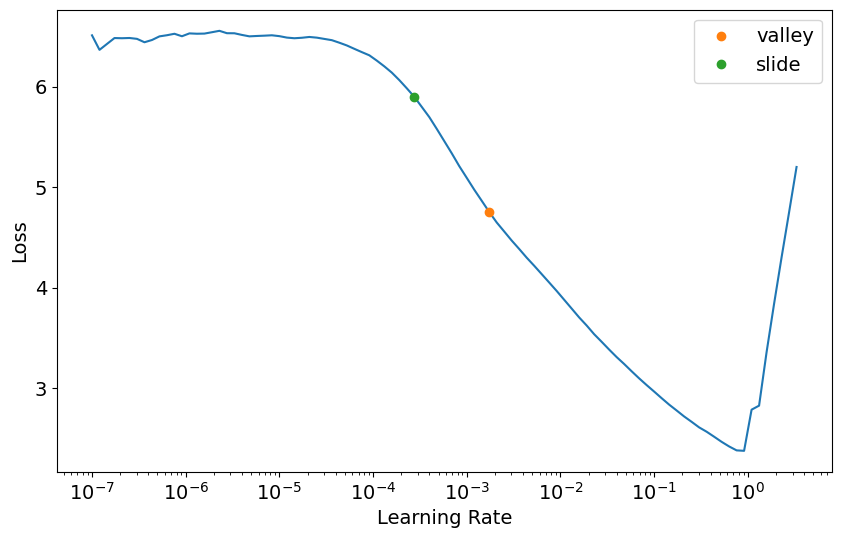

In [66]:
learn.lr_find(suggest_funcs=(valley,slide))

In [67]:
learn = tabular_learner(dls, y_range=(2,10.99), layers=[50,25,15],
                        n_out= 1, loss_func=F.mse_loss
                        )

In [68]:
learn.fit_one_cycle(10, 1e-4,wd=0.01) # weight decay

epoch,train_loss,valid_loss,time
0,4.339193,3.472715,00:00
1,3.885254,3.336951,00:00
2,3.124908,2.342419,00:00
3,2.470230,1.754872,00:00
4,1.960872,1.434215,00:00
5,1.597959,1.166603,00:00
6,1.334189,1.144812,00:00
7,1.162897,1.079761,00:00
8,1.039377,0.990793,00:00
9,0.967959,1.044557,00:00


In [69]:
preds, targets = learn.get_preds()

r_mse(preds, targets)

1.022036

# using the XGboost

In [70]:
from xgboost import XGBRegressor

In [83]:
to = load_pickle('./to_event.pkl')
y = to.train.y
valid_y = to.valid.y
xs = load_pickle('./xs_final.pkl')
valid_xs = load_pickle('./valid_xs_final.pkl')

In [72]:
def xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7,min_child_weight=3,**params):
      return XGBRegressor(random_state=42, n_jobs=-1, 
                       learning_rate= learning_rate, n_estimators= n_estimators,
                       max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree,
                       min_child_weight = min_child_weight, device='cuda').fit(xs,y)

In [73]:
m_rf = rf(xs,y)

In [74]:
# i think we can do better
# use more trees
xgb = xgboost(xs, y, learning_rate=0.1,
              n_estimators=5000, colsample_bytree=0.7, subsample=0.7,
              max_depth=2, min_child_weight=3)

[04:47:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.



In [75]:
preds_xgb = xgb.predict(valid_xs)
preds_rf = m_rf.predict(valid_xs)

In [76]:
r_mse(preds_rf,valid_y),r_mse(preds_xgb,valid_y)

(0.129206, 0.05218)

# Testing XGBOOST

In [77]:
# TESTING THE BOOSTING AND BAGGING METHODS


dl_test = to.dataloaders().test_dl(df_test)
xs_test, y_test = dl_test.train.xs, dl_test.train.y
xs_test = xs_test[xs.columns.to_list()]

In [78]:
RF_test = m_rmse(m_rf, xs_test, y_test)
XBG_test = m_rmse(xgb, xs_test, y_test)



print(f'Random Forest Test Result: { RF_test  }  || XGBOOST Test Result: { XBG_test } ')

Random Forest Test Result: 0.129213  || XGBOOST Test Result: 0.034759 


In [79]:
pred_rf = m_rf.predict(xs_test)
pred_xgb = xgb.predict(xs_test)

In [80]:
combined_preds = [pred_rf, pred_xgb]
preds  = np.stack(combined_preds).mean(0)
r_mse(preds,y_test)

0.071409

In [81]:
combined_predictions = [
    pred_rf * 0.1,
    pred_xgb * 0.89999999,
]

# Compute the weighted average
preds_weighted = np.sum(combined_predictions, axis=0)

# Calculate RMSLE of the ensemble
ensemble_rmsle = r_mse(preds_weighted, y_test)
print(f"Weighted Ensemble RMSLE: {ensemble_rmsle}")

Weighted Ensemble RMSLE: 0.037013


Wonderful results 😆

# using the Learners, One prediction

In [105]:
df1.columns

Index(['name', 'url', 'category', 'subcategory', 'location', 'status', 'goal',
       'pledged', 'funded percentage', 'backers', 'funded date', 'levels',
       'updates', 'comments', 'duration', 'year', 'level_0'],
      dtype='object')

In [116]:
categories = list(df1['category'].unique())
sub_cat = list(df1['subcategory'].unique())
loc = list(df1['location'].unique())
stat = list(df1['status'].unique())



# GUI

In [117]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input fields

name = widgets.Text(value="Point of Descent", description="Name:")

category = widgets.Dropdown(value=categories[1], options=categories ,description="Category:")

subcategory = widgets.Dropdown(value=sub_cat[18], options =sub_cat, description="subcategory:")


goal = widgets.FloatText(value=2500.0, description="Goal:")

location = widgets.Dropdown(value=loc[0],options=loc, description="location:")

status = widgets.Dropdown(value=stat[0],options=stat, description="status:")

funded_percentage = widgets.FloatText(value=1.038, description="funded percentage:")

backers = widgets.FloatText(value=21, description="backers:")


levels = widgets.FloatText(value=8, description="levels:")

updates = widgets.FloatText(value=6, description="updates:")

comments = widgets.FloatText(value=3, description="comments:")

duration = widgets.FloatText(value=91.0, description="duration:")


# Display widgets
display(name, category,subcategory, goal,location, status, funded_percentage, backers, levels, updates, comments, duration)

# Output widget for displaying updates
output = widgets.Output()
display(output)

data = {}

# Function to save values
def save_changes(b):
    # python default behavior is to treat the 
    # variables inside a function as local variables 
    # unless explicitly specified as global 
    global data
    # display(name, category, goal,location, status, funded_percentage, backers, funded_date, levels, updates, comments, duration)
    data = {
        "project id": 2623100,
        "name": name.value,
        "url": "http://www.kickstarter.com/projects/bmag-games/point-of-descent",
        "category": category.value,
        "subcategory": subcategory.value,
        "location": location.value,
        "status": status.value,
        "goal": goal.value,
        "pledged": 2595.0,
        "funded percentage": funded_percentage.value,
        "backers": backers.value,
        "funded date": "Sat, 25 Jun 2011 15:54:12 -0000",
        "levels": levels.value,
        "reward levels": "5, 10, 25, 25, 100, 100, 500, 500",
        "updates": updates.value,
        "comments": comments.value,
        "duration": duration.value,
        "reward levels" : "$5,$10,$25,$25,$100,$100,$500,$500"
        
    }

# Save button
save_button = widgets.Button(description="Save Changes", button_style='success')
save_button.on_click(save_changes)
display(save_button)

Text(value='Point of Descent', description='Name:')

Dropdown(description='Category:', index=1, options=('Film & Video', 'Games', 'Fashion', 'Art', 'Technology', '…

Dropdown(description='subcategory:', index=18, options=('Short Film', 'Board & Card Games', 'Animation', 'Fash…

FloatText(value=2500.0, description='Goal:')

Dropdown(description='location:', options=('Columbia, MO', 'Maplewood, NJ', 'Los Angeles, CA', 'Portland, OR',…

Dropdown(description='status:', options=('successful', 'failed', 'live', 'canceled', 'suspended'), value='succ…

FloatText(value=1.038, description='funded percentage:')

FloatText(value=21.0, description='backers:')

FloatText(value=8.0, description='levels:')

FloatText(value=6.0, description='updates:')

FloatText(value=3.0, description='comments:')

FloatText(value=91.0, description='duration:')

Output()

Button(button_style='success', description='Save Changes', style=ButtonStyle())

In [119]:
data

{'project id': 2623100,
 'name': 'Point of Descent',
 'url': 'http://www.kickstarter.com/projects/bmag-games/point-of-descent',
 'category': 'Games',
 'subcategory': 'Video Games',
 'location': 'Columbia, MO',
 'status': 'suspended',
 'goal': 2500.0,
 'pledged': 2595.0,
 'funded percentage': 1.038,
 'backers': 21.0,
 'funded date': 'Sat, 25 Jun 2011 15:54:12 -0000',
 'levels': 8.0,
 'reward levels': '$5,$10,$25,$25,$100,$100,$500,$500',
 'updates': 6.0,
 'comments': 3.0,
 'duration': 91.0}

## Converting the single prediction into a dataframe

In [115]:
df = pd.DataFrame([data])

In [116]:
df = all_data_preprocessing(df)

nan
nan
nan
Number of outliers: 0
nan
Number of outliers: 0
nan
Number of outliers: 0
nan


In [117]:
def one_prediction(df):
    dl_test = to.dataloaders().test_dl(df)
    xs_test, y_test = dl_test.train.xs, dl_test.train.y
    xs_test = xs_test[xs.columns.to_list()]
    return xs_test

In [118]:
df

,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,updates,comments,duration,year,level_0
0,Point of Descent,http://www.kickstarter.com/projects/bmag-games/point-of-descent,Games,Video Games,"Nanuet, NY",failed,7.427144,7.861727,0.181548,2.079442,2011-06-25 15:54:12+00:00,9.0,5.0,1.098612,45.0,2011,1.791759


In [119]:
xs_test = one_prediction(df)

In [120]:
pred_rf = m_rf.predict(xs_test)
pred_xgb = xgb.predict(xs_test)
print(np.exp(pred_rf))
print(np.exp(pred_xgb))

print(np.exp(7.8244))

[306.48264348]
[308.54578]
2500.885129513146


In [96]:
r_mse(pred_xgb,7.861727),r_mse(pred_rf,7.861727)

(0.004132, 0.010372)

In [97]:
combined_preds = [pred_rf, pred_xgb]
preds  = np.stack(combined_preds).mean(0)
r_mse(preds,7.861727)

0.007252

In [98]:
combined_predictions = [
    pred_rf * 0.1,
    pred_xgb * 0.89999999,
]

# Compute the weighted average
preds_weighted = np.sum(combined_predictions, axis=0)

# Calculate RMSLE of the ensemble
ensemble_rmsle = r_mse(preds_weighted, 7.861727)
print(f"Weighted Ensemble RMSLE: {ensemble_rmsle}")

Weighted Ensemble RMSLE: 0.004756


In [112]:
def final_one_prediction(df):
    xs_test = one_prediction(df)
    pred_rf = m_rf.predict(xs_test)
    pred_xgb = xgb.predict(xs_test)
    combined_predictions = [
    pred_rf * 0.1,
    pred_xgb * 0.89999999,
        ]

    # Compute the weighted average
    preds_weighted = np.sum(combined_predictions, axis=0)

    print(f'Predicted Pledged: $ {np.exp(preds_weighted[0]):.2f}')


In [113]:
final_one_prediction(df)

Predicted Pledged: $ 2608.38


# Notes: 
-  joblib file 
- select options for category, subcategory 
- run it all :)


In [120]:
m_rf,xgb

(RandomForestRegressor(max_features=0.5, max_samples=26562, min_samples_leaf=4,
                       n_estimators=500, n_jobs=-1, oob_score=True),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...))

# Export the Models to use them locally

In [122]:
import joblib
export_data = dict(
  xgb = xgb,
  rf = m_rf
)

expect_pledge= export_data



In [123]:
joblib.dump(expect_pledge,'event_pledged.joblib')

['event_pledged.joblib']

# Load the Models

In [128]:

data = joblib.load("event_pledged.joblib")


rf = data['rf']
xgbR = data['xgb']